In [1]:
'''
The notebook takes all the images in a Map & gis data, creates word variations, 
runs phoc and gets the closest match to every clip in the map. 
Based on the matched word variation we get the direction the clip should 
be extended in and store it in a separate file. Below cells also contain
some analysis on how phoc performs using gis data, the top 10 neighbors etc
'''

import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [2]:
word_filter_len = 1 # only words above this length are considered valid
max_var_len = 1

In [3]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [4]:
model_ = torch.load('models/PHOCNet_Nov13.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [5]:
from strlocale import BasicLocale

def clean_words(words):
    lc = BasicLocale()
    for i, w in enumerate(words):
        try:
            words[i] = lc.represent(w).encode('ascii',errors='ignore')
        except:
            words[i] = w
    return words

def load_and_transform(map_name):
    images = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_regions/'+map_name+'.npy')
    words = np.load('/mnt/nfs/work1/696ds-s18/mbhargava/detection_outputs_ready_for_test/ray_labels/'+map_name+'.npy')
    images = np.transpose(images, (0,3,1,2))
    words = clean_words(words)
    print 'Images Shape ', images.shape
    print 'Words Shape ', words.shape
    return images, words

def load_and_clean_gis_data():
    with open('../GIS_data/GIS_combined.txt') as f:
        gis_data = np.array(f.read().splitlines())
    gis_data = clean_words(gis_data)
    print 'GIS Data', gis_data.shape
    return gis_data

In [6]:
def gen_img_phoc_embs(cnn, images):
    outputs = []
    for i in tqdm(range(len(images)), ascii=True, desc='Converting Images to Embeddings'):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

In [7]:
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor

def insert_dict_set(dct, key, val):
    if key not in dct:
        dct[key] = set()
    dct[key].add(val)
    
# the method defines the rules to handle multiple dir associated with a given word
# returns conf_words which is a set of word_var where this confusion exists
# word_var: dictionary from word -> chosen_dir. Incase a word has multiple dir
# the following preference order is followed 0 > (1,-1) > (2,-2) > (3,-3) ...
def handle_word_conf(comp_word_var):
    word_var = {}
    conf_words = set()
    for var in comp_word_var.keys():
        dirs = np.array(list(comp_word_var[var]))
        if(len(dirs) == 1):
            word_var[var] = dirs[0]
        else:
            conf_words.add(var)
            idx = np.argmin(np.abs(dirs))
            word_var[var] = dirs[idx]
    return word_var, conf_words

# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
# enable_conf: boolean flag that controls if the confusion logic should be used.
# when enabled if a word is a root word as well as a word variation (happens if root words ar rand and grand)
# it marks it as to be extended and also stores it in the confusion list
def create_word_variations(words, enable_conf=False):
    word_var = {}
    root_word_var = {}
    # create the root word variation dict and set word_var as -1 or +1
    for w in words:
        root_var_list = [w, w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            for l in range(1,max_var_len+1):
                if len(w) <= l:
                    continue
                insert_dict_set(word_var, var, 0)
                insert_dict_set(word_var, var[l:], l)
                insert_dict_set(word_var, var[:-l], -l)
                var_set.add(var)
                var_set.add(var[l:])
                var_set.add(var[:-l])
        root_word_var[w] = var_set
    word_var, conf_words = handle_word_conf(word_var)
    return word_var, root_word_var, conf_words

def gen_text_phoc_embs(words):
    word_strings = words
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    
    word_var_dir, root_word_var, conf_words = create_word_variations(word_strings, enable_conf=True)
    
    embedding = build_phoc_descriptor(words=word_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    return (embedding, embedding_var, word_var_strings, word_var_dir, root_word_var, conf_words)
    

In [8]:
# the new report matches method that handles variations
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches_with_variations(outputs, embedding, matching, ground_truth, 
                                   words, word_var_dir, root_word_var, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(ground_truth)) if len(ground_truth[x]) > length]
    outputs = np.array(outputs)
    ground_truth = np.array(ground_truth)
    outputs = list(outputs[qualified_ids])
    ground_truth = list(ground_truth[qualified_ids])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    min_ext_len = 3
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            matched.append(words[j])
            curr_len = len(words[j])
            curr_dir = word_var_dir[words[j]]
            if len(ground_truth[i]) < min_ext_len:
                curr_dir = 0
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    for i in range(len(ground_truth)):
        #print word_strings[i]
        if ground_truth[i].lower() in [mw.lower() for mw in matched_words[i]]:
            count = count+1
        else:
            for w in matched_words[i]:
                if ground_truth[i] in root_word_var and w in root_word_var[ground_truth[i]]:
                    count = count+1
                    break

    return (count, matched_words, qualified_ids, img_dir, words_len, outputs, ground_truth, dist_mat)

In [9]:
# the old original report matches method
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches(outputs, embedding, matching, words, ground_truth, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(ground_truth)) if len(ground_truth[x]) > length]
    outputs = np.array(outputs)
    ground_truth = np.array(ground_truth)
    outputs = list(outputs[qualified_ids])
    ground_truth = list(ground_truth[qualified_ids])
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            matched.append(words[j])
        matched_words.append(matched)
    
    for i in range(len(ground_truth)):
        if ground_truth[i].lower() in [mw.lower() for mw in matched_words[i]]:
            count = count+1

    return (count, matched_words, outputs, embedding, ground_truth, qualified_ids, dist_mat)

In [10]:
# given the image name, this driver function computes the following
# 1. loads the words and images and transforms them based on image name
# 2. generates embeddings for images using the cnn model
# 3. gets the original and variation embeddings
# 4. generate report with word variations (prints accuracy)
# 5. generate report original (prints accuracy)
# 6. returns the image_dir_info that needs to be saved as numpy files
def image_ext_with_word_var(map_name, cnn, gis_data, text_phoc_info, global_stats):
    images, words = load_and_transform(map_name)
    img_phoc_embs = gen_img_phoc_embs(cnn, images)
    embedding, embedding_var, word_var_strings, word_var_dir, root_word_var, conf_set = text_phoc_info
    original_report = report_matches(img_phoc_embs, embedding, 'cosine', gis_data, words, 1, word_filter_len)
    global_stats['correct_original'] += original_report[0]
    print 'Original Accuracy ', str(original_report[0]/float(len(original_report[4])))
    word_var_report = report_matches_with_variations(img_phoc_embs, embedding_var,'cosine', words, word_var_strings, word_var_dir, root_word_var, 1, word_filter_len)
    global_stats['correct_word_var'] += word_var_report[0]
    print 'Accuracy With Word Variations ', str(word_var_report[0]/float(len(word_var_report[4])))
    global_stats['total'] += len(word_var_report[4])
    img_dir_info = np.array([word_var_report[2], word_var_report[3], word_var_report[4]])
    return img_dir_info, word_var_report[6], conf_set, original_report, word_var_report
    

In [11]:
gis_data = load_and_clean_gis_data()
text_phoc_info = gen_text_phoc_embs(gis_data)

GIS Data (477196,)


100%|██████████| 1290899/1290899 [04:58<00:00, 4330.59it/s]


In [12]:
A = ['D0042-1070001']

In [13]:
global_stats = {'correct_original':0, 'correct_word_var':0, 'total':0}

original_report = None
word_var_report = None
for i in tqdm(range(len(A)), ascii=True, desc = 'Main Iteration'):
    print A[i]
    img_dir_info, words, conf_words, original_report,word_var_report = image_ext_with_word_var(A[i], cnn, gis_data, text_phoc_info, global_stats)
    # np.save('../../../images_to_extend/image_dir_'+A[i]+'.npy', img_dir_info)
    # np.save('../../../images_to_extend/image_labels_'+A[i]+'.npy', words)
print 'Accuracy Original', global_stats['correct_original']/float(global_stats['total'])
print 'Accuracy With Word Variations', global_stats['correct_word_var']/float(global_stats['total'])

D0042-1070001
Images Shape  (1192, 3, 135, 487)
Words Shape  (1192,)


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdDb252ZXJ0aW5nIEltYWdlcyB0byBFbWJlZGRpbmdzJywgbWF4PTExOTIpLCBIVE1MKHZhbHVlPXUnJynigKY=


Original Accuracy  0.287184284378
Accuracy With Word Variations  0.357343311506

Accuracy Original 0.287184284378
Accuracy With Word Variations 0.357343311506


In [14]:
count, matched_words, outputs, embedding, ground_truth, qualified_ids, dist_mat = original_report
print(len(matched_words))
for i in range(len(matched_words)):
    if matched_words[i][0].lower() == ground_truth[i]:
        print i, matched_words[i], ground_truth[i]

1069
52 ['eastern'] eastern
85 ['and'] and
113 ['and'] and
119 ['abound'] abound
124 ['and'] and
131 ['generally'] generally
140 ['beds'] beds
141 ['thickness'] thickness
160 ['2d'] 2d
162 ['frequent'] frequent
166 ['the'] the
172 ['of'] of
179 ['and'] and
188 ['abound'] abound
219 ['in'] in
232 ['the'] the
233 ['13'] 13
236 ['10'] 10
243 ['14'] 14
280 ['14'] 14
286 ['10'] 10
291 ['the'] the
308 ['12'] 12
315 ['throughout'] throughout
330 ['15'] 15
331 ['13'] 13
334 ['10'] 10
338 ['12'] 12
474 ['12'] 12
487 ['12'] 12
488 ['13'] 13
506 ['12'] 12
507 ['11'] 11
525 ['16'] 16
547 ['14'] 14
691 ['12'] 12
694 ['abound'] abound
697 ['throughout'] throughout
718 ['beds'] beds
750 ['and'] and
766 ['and'] and
773 ['thickness'] thickness
777 ['the'] the
781 ['frequent'] frequent
791 ['and'] and
832 ['2d'] 2d
873 ['the'] the
920 ['14'] 14
976 ['12'] 12


In [15]:
sorted_dist = np.argsort(dist_mat, axis=1)

In [16]:
def get_gis_word_idx(word):
    idx = []
    for i in range(len(gis_data)):
        if word.lower() == gis_data[i].lower():
            idx.append(i)
    return idx

In [17]:
images, words = load_and_transform(A[0])

Images Shape  (1192, 3, 135, 487)
Words Shape  (1192,)


************************************************************************
************************************************************************
Original image:


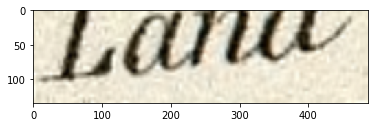

top 10 matches are:  ['Lann', 'Lano', 'Lana', 'Land', 'Lane', 'Lant', 'Lanz', 'Lang', 'Lanx', 'Lank']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


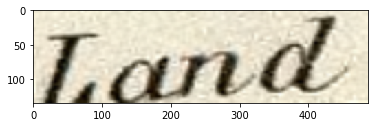

top 10 matches are:  ['Land', 'Landa', 'Lando', 'Lands', 'Landy', 'Lande', 'LandI', 'Ladd', 'Lanny', 'Lad']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


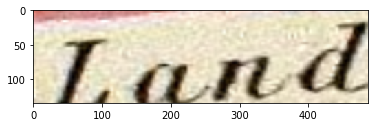

top 10 matches are:  ['Land', 'Ladd', 'Lann', 'Lana', 'land', 'Laid', 'Lard', 'Laud', 'sand', 'Gand']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


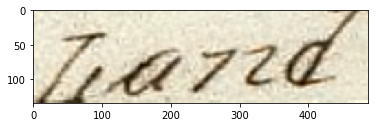

top 10 matches are:  ['Land', 'land', 'Ladd', 'Lann', 'hand', 'rand', 'sand', 'band', 'wand', 'Wand']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


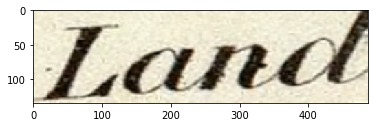

top 10 matches are:  ['Land', 'Lann', 'Ladd', 'Lana', 'sand', 'Lanz', 'Lang', 'band', 'Lanx', 'Lank']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


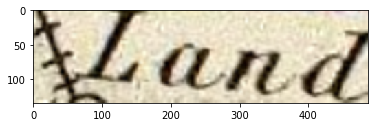

top 10 matches are:  ['Land', 'Lann', 'Ladd', 'Lana', 'land', 'Band', 'sand', 'Gand', 'Sand', 'band']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


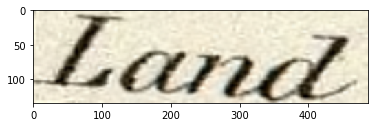

top 10 matches are:  ['Land', 'Ladd', 'Lann', 'Lana', 'Lond', 'Lend', 'Lund', 'Lind', 'Lynd', 'Laid']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


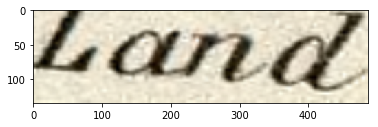

top 10 matches are:  ['Land', 'Lad', 'Landa', 'Leaned', 'Lando', 'Lands', 'Landy', 'Lande', 'LandI', 'Loaned']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


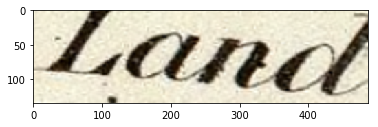

top 10 matches are:  ['Land', 'Lano', 'Lond', 'Lann', 'Ladd', 'Lana', 'Lant', 'Lanz', 'Lang', 'Lank']
------------------------------------------------------------------------
------------------------------------------------------------------------


In [20]:
import matplotlib.pyplot as plt
# analysis of land image
gis_word_idx = set(get_gis_word_idx('land'))
img_ids = set([38, 73, 116, 158, 248, 711, 712, 716, 817])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    #print "the matched words are (inorder): "+str(matched_words[i])
    #print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            #print "closest correct match in dist matrix", p
            break
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

************************************************************************
************************************************************************
Original image:


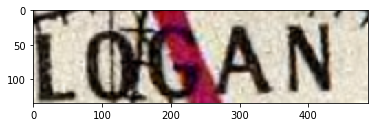

the matched words are (inorder): ['LOAN']
the gound truth is:LOGAN
closest correct match in dist matrix 1
top 10 matches are:  ['LOAN', 'LOGAN', 'LORAN', 'LOMAN', 'JOAN', 'DOAN', 'ROAN', 'COAN', 'MOAN', 'OLAN']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


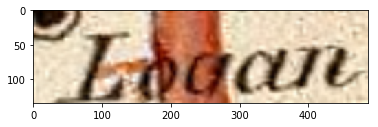

the matched words are (inorder): ['Logan']
the gound truth is:Logan
closest correct match in dist matrix 0
top 10 matches are:  ['Logan', 'logan', 'hogan', 'Cogan', 'Bogan', 'Hogan', 'Rogan', 'Nogan', 'Lagan', 'organ']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


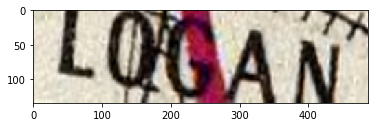

the matched words are (inorder): ['LOAN']
the gound truth is:LOGAN
closest correct match in dist matrix 1
top 10 matches are:  ['LOAN', 'LOGAN', 'LOMAN', 'LORAN', 'LON', 'NOLAN', 'GOLAN', 'DOLAN', 'LONGAN', 'LONAS']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


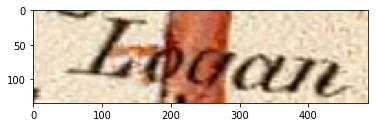

the matched words are (inorder): ['Logan']
the gound truth is:Logan
closest correct match in dist matrix 0
top 10 matches are:  ['Logan', 'Lagan', 'Luggan', 'Lagas', 'Lagai', 'Legas', 'Legat', 'Legal', 'Lugar', 'Bogan']
------------------------------------------------------------------------
------------------------------------------------------------------------


In [21]:
import matplotlib.pyplot as plt
# analysis of logan image
gis_word_idx = set(get_gis_word_idx('logan'))
img_ids = set([50,246,695,769])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of 1866 image
gis_word_idx = set(get_gis_word_idx('1866'))
img_ids = set([70, 483, 757])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of Crawford image
gis_word_idx = set(get_gis_word_idx('CRAWFORD'))
img_ids = set([76, 698])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of state image
gis_word_idx = set(get_gis_word_idx('state'))
img_ids = set([99, 120, 225, 741, 799])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of FAIRFIELD image
gis_word_idx = set(get_gis_word_idx('FAIRFIELD'))
img_ids = set([156, 962])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of 13 image
gis_word_idx = set(get_gis_word_idx('13'))
img_ids = set([222, 233, 270, 331, 471, 488, 549, 685, 813, 957])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"

In [ ]:
import matplotlib.pyplot as plt
# analysis of 13 image
gis_word_idx = set(get_gis_word_idx('great'))
img_ids = set([355, 561])
for i in range(len(matched_words)):
    if i not in img_ids:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(images[qualified_ids[i]],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "the gound truth is:" + str(ground_truth[i])
    for p,j in enumerate(sorted_dist[i]):
        if j in gis_word_idx:
            print "closest correct match in dist matrix", p
            break
    if p == len(sorted_dist[i])-1:
        print "did not find the word in gis data"
    print "top 10 matches are: ", [gis_data[j] for j in sorted_dist[i][:10]]
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"